# Train Agent

## Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from collections import namedtuple, Counter
from ipywidgets import *
from IPython.display import display, HTML

from santorinigo.environment import Santorini
from santorinigo.qnetwork import *
from santorinigo.replay_memory import *
from santorinigo.agent import Agent

DATA_PATH = 'data/'
MODEL_PATH = f'{DATA_PATH}models/'

## Environment

In [2]:
env = Santorini()
env.print_board()

Buildings:
 [[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Workers:
 [[ 0  0 -1  0  0]
 [ 0  0  0  0  0]
 [ 1  0  0  0  2]
 [ 0  0  0  0  0]
 [ 0  0 -2  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 22  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 18]]


In [3]:
env.step(27)

(array([[[ 1,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0]],
 
        [[ 0, -1,  0,  0,  0],
         [ 0,  0,  0,  0,  0],
         [ 1,  0,  0,  0,  2],
         [ 0,  0,  0,  0,  0],
         [ 0,  0, -2,  0,  0]]]), -0.001, False, 1)

In [4]:
env.print_board()

Buildings:
 [[1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Workers:
 [[ 0 -1  0  0  0]
 [ 0  0  0  0  0]
 [ 1  0  0  0  2]
 [ 0  0  0  0  0]
 [ 0  0 -2  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 21  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 18]]


In [5]:
env.legal_moves()[:10]

[9, 12, 14, 15, 16, 18, 19, 20, 21, 22]

In [6]:
p1_action = env.atoi[(-1,'x','d')]; p1_action

52

In [7]:
env.step(p1_action), env.print_board()

Buildings:
 [[1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]]
Workers:
 [[ 0 -1  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  2]
 [ 1  0  0  0  0]
 [ 0  0 -2  0  0]]
Parts:
 [[ 0  0  0  0  0]
 [ 0 20  0  0  0]
 [ 0  0 18  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 18]]


((array([[[ 1,  0,  0,  0,  0],
          [ 0,  0,  0,  0,  0],
          [ 0,  0,  0,  0,  0],
          [ 0,  1,  0,  0,  0],
          [ 0,  0,  0,  0,  0]],
  
         [[ 0,  1,  0,  0,  0],
          [ 0,  0,  0,  0,  0],
          [ 0,  0,  0,  0, -2],
          [-1,  0,  0,  0,  0],
          [ 0,  0,  2,  0,  0]]]), -0.001, False, -1), None)

In [8]:
p2_action = env.atoi[(-1,'d','d')]; p2_action

36

In [9]:
env.step(p2_action)

(array([[[ 1,  0,  0,  1,  0],
         [ 0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0],
         [ 0,  1,  0,  0,  0],
         [ 0,  0,  0,  0,  0]],
 
        [[ 0,  0, -1,  0,  0],
         [ 0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  2],
         [ 1,  0,  0,  0,  0],
         [ 0,  0, -2,  0,  0]]]), -0.001, False, 1)

In [10]:
env.action_dim, env.state_dim_flat

(128, 2)

## Agent

In [11]:
#memories
mem1 = PrioritizedMemory(capacity = 1000)
mem2 = PrioritizedMemory(capacity = 1000)
#agents
a1 = Agent(state_size = env.state_dim_flat, action_size = env.action_dim, 
           env = env, replay_memory = mem1, seed = 1412,
           lr = 1e-3 / 4, bs = 64, nb_hidden = 128,
           gamma=0.99, tau= 1/100, update_interval = 5)
a2 = Agent(state_size = env.state_dim_flat, action_size = env.action_dim, 
           env = env, replay_memory = mem2, seed = 1412,
           lr = 1e-3 / 4, bs = 64, nb_hidden = 128,
           gamma=0.99, tau= 1/100, update_interval = 5)

In [12]:
winners = []
timesteps = []
game_records = []

env = Santorini()
for i in trange(100000):
    state = env.reset()
    timestep = 0
    game_record = [env.board]
    while True:
        
        #select action
        if timestep % 2 ==0:
            action = a1.act(state,i,legal_actions=None)
        else:
            action = a2.act(state,i,legal_actions=None)
        
        #step environment
        next_state,reward,done,next_player = env.step(action)
        game_record.append(env.board)
        
            
        #step agent; store transition and train
        if timestep % 2 ==0:
            a1.step(state,action,reward,next_state,done,i)
        else:
            a2.step(state,action,reward,next_state,done,i)
        
        #end timestep
        timestep+=1    
        
        #break if done
        if done: break
            
    #record
    winners.append(-next_player)
    timesteps.append(timestep)
    game_records.append(game_record)
    #print(f'Player {current_player} wins in {timestep} turns')
    if i % 9999 == 0:
        torch.save(a1.qnetwork_local.state_dict(), f'{MODEL_PATH}half_rainbow_{i}.m')

  0%|          | 0/100000 [00:00<?, ?it/s]/home/charin/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/nn/functional.py:54: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 27769/100000 [21:27<55:48, 21.57it/s]

KeyboardInterrupt: 

In [13]:
Counter(winners)

Counter({-1: 2675, 1: 25095})

In [14]:
game_records[np.argmax(timesteps)][-1]

array([[[ 0,  1,  0,  0,  0],
        [ 0,  1,  1,  0,  0],
        [ 1,  1,  2,  1,  0],
        [ 0,  0,  1,  1,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 0, -2, -1,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  2],
        [ 0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0, 13,  0,  0,  0],
        [ 0,  0, 17,  0,  0],
        [ 0,  0,  0, 14,  0],
        [ 0,  0,  0,  0, 18]]])

(5.5803745048613616, 1, 11)

 28%|██▊       | 27769/100000 [21:40<56:22, 21.35it/s]

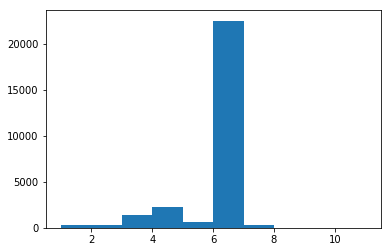

In [15]:
plt.hist(timesteps)
np.mean(timesteps),np.min(timesteps),np.max(timesteps)

In [16]:
game_records[-1][-1]

array([[[ 0,  0,  1,  0,  0],
        [ 1,  0,  1,  0,  0],
        [ 1,  0,  1,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  2],
        [ 0,  0, -1,  0,  0],
        [ 0,  0, -2,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0, 17,  0,  0,  0],
        [ 0,  0, 18,  0,  0],
        [ 0,  0,  0, 14,  0],
        [ 0,  0,  0,  0, 18]]])

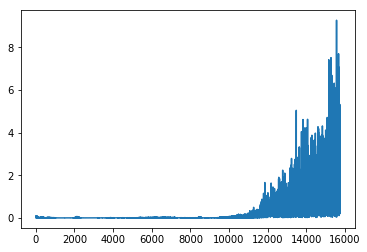

In [17]:
plt.plot(a1.losses)